Step 1: First 5 rows:
              meantemp   humidity  wind_speed  meanpressure
date                                                      
2017-01-01  15.913043  85.869565    2.743478     59.000000
2017-01-02  18.500000  77.222222    2.894444   1018.277778
2017-01-03  17.111111  81.888889    4.016667   1018.333333
2017-01-04  18.700000  70.050000    4.545000   1015.700000
2017-01-05  18.388889  74.944444    3.300000   1014.333333
Step 2: Differences between consecutive timestamps:
 diff
1 days    113
Name: count, dtype: int64
Step 3: Missing dates: DatetimeIndex([], dtype='datetime64[ns]', freq='D')
Step 4: After filling missing values:
              meantemp   humidity  wind_speed  meanpressure   diff
2017-01-01  15.913043  85.869565    2.743478     59.000000    NaT
2017-01-02  18.500000  77.222222    2.894444   1018.277778 1 days
2017-01-03  17.111111  81.888889    4.016667   1018.333333 1 days
2017-01-04  18.700000  70.050000    4.545000   1015.700000 1 days
2017-01-05  18.388889 

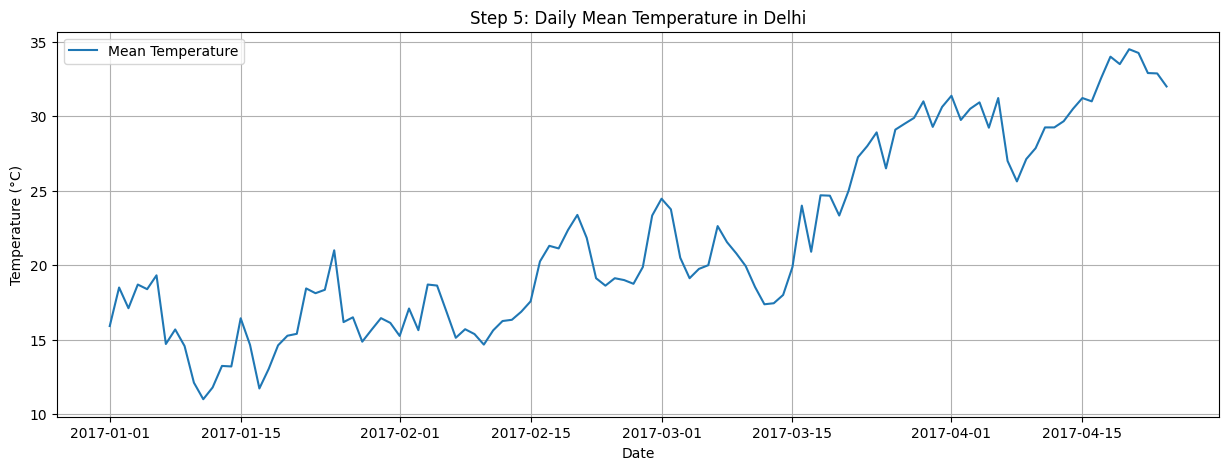

Step 6: Using seasonal period = 30


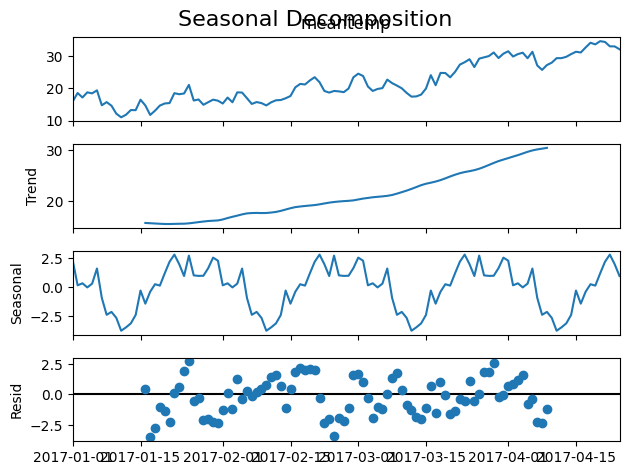

Step 7: Train/Val/Test sizes: 85 17 12


Rolling: 100%|██████████| 38/38 [00:05<00:00,  6.49it/s]

Feature Extraction:   0%|          | 0/38 [00:00<?, ?it/s]

In [ ]:
# ================================
# Lab 4: Daily Delhi Climate Dataset
# Full solution (steps 1–19) with automated features
# ================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf

# Automated feature extraction
from tsfresh import extract_features
from tsfresh.utilities.dataframe_functions import make_forecasting_frame

# ================================
# 1. Load Dataset & Convert Dates
# ================================
df = pd.read_csv("data/DailyDelhiClimateTest.csv")
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
df.set_index('date', inplace=True)
print("Step 1: First 5 rows:\n", df.head())

# ================================
# 2. Identify frequency
# ================================
df['diff'] = df.index.to_series().diff()
print("Step 2: Differences between consecutive timestamps:\n", df['diff'].value_counts())

# ================================
# 3. Check missing dates
# ================================
full_dates = pd.date_range(df.index.min(), df.index.max(), freq='D')
missing_dates = full_dates.difference(df.index)
print("Step 3: Missing dates:", missing_dates)

# ================================
# 4. Complete daily index & fill missing values
# ================================
df = df.reindex(full_dates)
df.ffill(inplace=True)  # Forward fill missing values
print("Step 4: After filling missing values:\n", df.head())

# ================================
# 5. Plot Temperature Series
# ================================
plt.figure(figsize=(15,5))
plt.plot(df['meantemp'], label='Mean Temperature')
plt.title('Step 5: Daily Mean Temperature in Delhi')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.grid(True)
plt.show()

# ================================
# 6. Seasonal Decomposition (automated period)
# ================================
def get_season_period(n_obs, default_period=365):
    if n_obs >= 2 * default_period:
        return default_period
    elif n_obs >= 2 * 30:
        return 30
    elif n_obs >= 2 * 7:
        return 7
    else:
        return max(2, n_obs // 2)

season_period = get_season_period(len(df))
print(f"Step 6: Using seasonal period = {season_period}")
result = seasonal_decompose(df['meantemp'], model='additive', period=season_period)
result.plot()
plt.suptitle("Seasonal Decomposition", fontsize=16)
plt.show()

# ================================
# 7. Split into Train/Validation/Test
# ================================
n = len(df)
train_end = int(n * 0.75)
val_end = int(n * 0.90)

train = df.iloc[:train_end]
val = df.iloc[train_end:val_end]
test = df.iloc[val_end:]

print("Step 7: Train/Val/Test sizes:", len(train), len(val), len(test))

# ================================
# 8. Datetime Features + Cyclic Encoding
# ================================
df['day_of_week'] = df.index.dayofweek
df['month'] = df.index.month
df['week_of_year'] = df.index.isocalendar().week
df['day_of_year'] = df.index.dayofyear
df['is_weekend'] = df['day_of_week'].isin([5,6]).astype(int)

# Cyclic encoding
df['month_sin'] = np.sin(2*np.pi*df['month']/12)
df['month_cos'] = np.cos(2*np.pi*df['month']/12)
df['dow_sin'] = np.sin(2*np.pi*df['day_of_week']/7)
df['dow_cos'] = np.cos(2*np.pi*df['day_of_week']/7)

# ================================
# 9. Automated features using tsfresh
# ================================
df_reset = df.reset_index().rename(columns={'index':'date'})
df_f, y = make_forecasting_frame(
    df_reset['meantemp'], kind="meantemp", max_timeshift=30, rolling_direction=1
)
automated_features = extract_features(df_f, column_id="id", column_sort="time", column_value="value",
                                      impute_function=None, show_warnings=False)
print("Step 9: Automated features shape:", automated_features.shape)
print(automated_features.head())

# ================================
# 10. Lag features for visualization
# ================================
df['lag_7'] = df['meantemp'].shift(7)
df['lag_30'] = df['meantemp'].shift(30)
df['lag_90'] = df['meantemp'].shift(90)

plt.figure(figsize=(15,5))
df[['meantemp','lag_7','lag_30','lag_90']].plot()
plt.title('Step 10: Observed Temperature and Lag Features')
plt.grid(True)
plt.show()

# ================================
# 11-12. SMA and EMA
# ================================
df['SMA_7'] = df['meantemp'].rolling(7).mean()
df['SMA_30'] = df['meantemp'].rolling(30).mean()
df['SMA_90'] = df['meantemp'].rolling(90).mean()
df['EMA_14'] = df['meantemp'].ewm(span=14, adjust=False).mean()

plt.figure(figsize=(15,5))
plt.plot(df['meantemp'], label='Original')
plt.plot(df['SMA_7'], label='SMA-7')
plt.plot(df['SMA_30'], label='SMA-30')
plt.plot(df['SMA_90'], label='SMA-90')
plt.plot(df['EMA_14'], label='EMA-14')
plt.title('Step 11-12: SMA vs EMA')
plt.legend()
plt.grid(True)
plt.show()

# ================================
# 13-14. Rolling Std, Min, Max
# ================================
df['rolling_std_7'] = df['meantemp'].rolling(7).std()
df['rolling_std_30'] = df['meantemp'].rolling(30).std()
df['rolling_std_90'] = df['meantemp'].rolling(90).std()
df['rolling_min_30'] = df['meantemp'].rolling(30).min()
df['rolling_max_30'] = df['meantemp'].rolling(30).max()

plt.figure(figsize=(15,5))
plt.plot(df['meantemp'], label='Original')
plt.plot(df['rolling_min_30'], label='Rolling Min-30')
plt.plot(df['rolling_max_30'], label='Rolling Max-30')
plt.title('Step 13-14: Rolling Std, Min, Max')
plt.legend()
plt.grid(True)
plt.show()

# ================================
# 15. Target variable: next-day temperature
# ================================
df['target'] = df['meantemp'].shift(-1)
print("Step 15: Target column created")

# ================================
# 16. Stationarity check
# ================================
def adf_test(series):
    result = adfuller(series.dropna())
    print(f"ADF Statistic: {result[0]}")
    print(f"p-value: {result[1]}")
    print("Critical Values:", result[4])
    if result[1] < 0.05:
        print("Series is stationary")
    else:
        print("Series is NOT stationary")

print("Step 16: ADF Test")
adf_test(df['meantemp'])

plt.figure(figsize=(12,4))
plt.subplot(121)
plt.plot(df['meantemp'].rolling(30).mean(), label='Rolling Mean')
plt.plot(df['meantemp'], alpha=0.5, label='Original')
plt.title('Rolling Mean (30 days)')
plt.legend()
plt.subplot(122)
plt.plot(df['meantemp'].rolling(30).std(), label='Rolling Std')
plt.title('Rolling Std (30 days)')
plt.legend()
plt.show()

plt.figure(figsize=(12,4))
plot_acf(df['meantemp'].dropna(), lags=50)
plt.title('Autocorrelation Function (ACF)')
plt.show()

# ================================
# 17. Make series stationary
# ================================
df['meantemp_diff_1'] = df['meantemp'].diff(1)
df['meantemp_diff_30'] = df['meantemp'].diff(30)

plt.figure(figsize=(15,5))
plt.plot(df['meantemp_diff_1'], label='1-day differenced')
plt.plot(df['meantemp_diff_30'], label='30-day differenced')
plt.title('Step 17: Differenced Series')
plt.legend()
plt.grid(True)
plt.show()

print("ADF Test after 1-day differencing")
adf_test(df['meantemp_diff_1'])

# ================================
# 18. Downsample to weekly
# ================================
weekly = df['meantemp'].resample('W').mean()
plt.figure(figsize=(15,5))
plt.plot(weekly, label='Weekly Mean Temperature')
plt.title('Step 18: Weekly Downsampled Series')
plt.legend()
plt.grid(True)
plt.show()

# ================================
# 19. Upsample to hourly
# ================================
hourly = df['meantemp'].resample('H').interpolate()
plt.figure(figsize=(15,5))
plt.plot(hourly, label='Hourly Interpolated Temperature')
plt.title('Step 19: Hourly Upsampled Series')
plt.legend()
plt.grid(True)
plt.show()